In [102]:
using DrWatson
@quickactivate :SwARExperiments

In [103]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [104]:
using Plots
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

## Switching AR

## Generate AR

In [151]:
seed = 2
n_samples = 5000
n_states = 3
ar_order = 3
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.01, 0.1, 1.0, 10.0, 100.0], n_states, replace=false)
# prec_set  = sample(MersenneTwister(seed), [inv(0.00012076092747935885), inv(0.0005755920568259142)], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0), GammaShapeRate{Float64}(a=1.0e7, b=100000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
, MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
, MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
], [(3, [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]), (3, [1

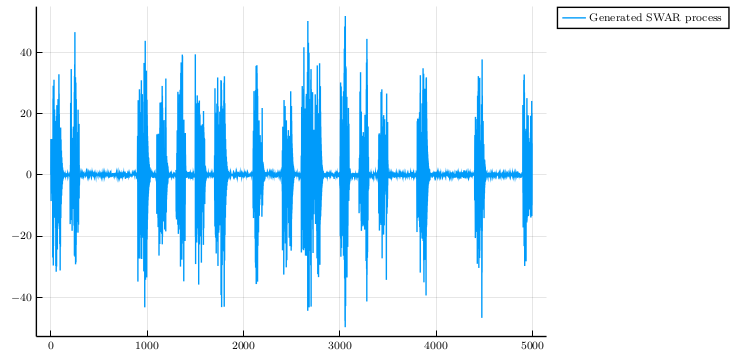

In [152]:
plot(outputs, label="Generated SWAR process")

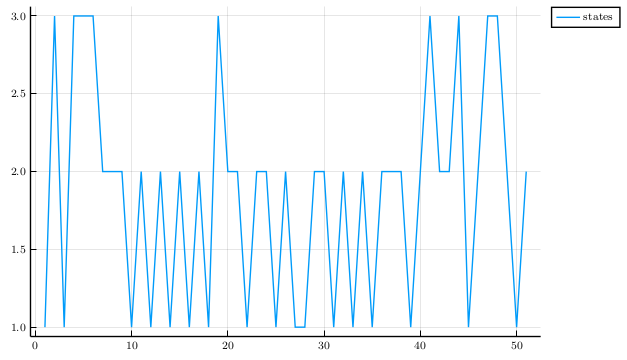

In [153]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

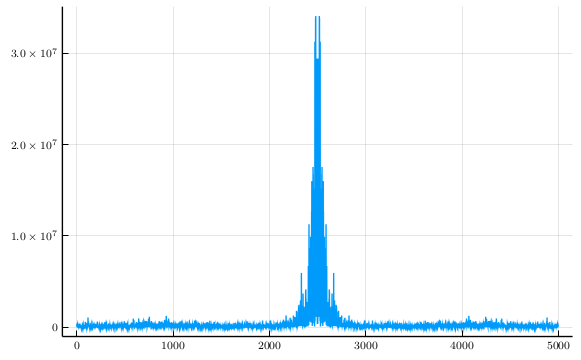

In [154]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

In [155]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(3, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0), GammaShapeRate{Float64}(a=1.0e7, b=100000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
, MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
, MvNormalMeanPrecision(
μ: [-0.26007710474968765, 0.29049659536661193, -0.3635063874585489]
Λ: [-0.02759118163692181 0.0 0.0; 0.0 0.6281364919630897 0.0; 0.0 0.0 -0.15400823258603086]
)
], [(3, [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 

In [156]:
result = InferenceResults(inference_swar(inputs, outputs, 50, 20, parameters)...);

Progress:  35%|██████████████▍                          |  ETA: 0:00:02

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [157]:
mean(result.mA[end])

3×3 Matrix{Float64}:
 0.962006   0.371106  0.371106
 0.0189971  0.314447  0.314447
 0.0189971  0.314447  0.314447

In [158]:
gen_A

3×3 Matrix{Float64}:
 0.179072  0.412007  0.122929
 0.554723  0.385573  0.365476
 0.266205  0.20242   0.511595

In [159]:
mean.(result.mθs[end])

50-element Vector{Vector{Float64}}:
 [0.9999999999999998, -1.647348259004682e-16, 0.0]
 [1.0000000000000009, -1.7996511012150362e-16, 6.655483267238846e-16]
 [1.0, 0.0, 0.0]
 [0.9999999999999992, 9.026880094247552e-16, -8.188002097292711e-16]
 [0.9999999999999978, 1.6787004662614672e-15, -1.9170027975198668e-15]
 [0.9999999999999988, 1.574036264051439e-15, -1.4224137020454387e-15]
 [0.9999999999999998, 1.1566872230809558e-16, 0.0]
 [1.0, 1.9685686122871504e-16, 0.0]
 [1.0, 2.5441985869352873e-16, -2.4464635971279606e-16]
 [1.0000000000000009, -2.726513099816392e-17, -8.207792465017169e-16]
 ⋮
 [1.0, 1.892765316665356e-16, 0.0]
 [0.9999999999999994, 8.527845604159405e-17, 3.669133754861466e-16]
 [0.999999999999999, 5.206648455458761e-16, -9.5151126145521e-16]
 [0.9999999999999994, -2.0699400038017616e-16, 1.531321300285464e-16]
 [1.0000000000000018, -1.3764174199552147e-16, -1.7143837952807548e-15]
 [0.9999999999999978, 1.6635364653515439e-15, -2.2143850721513647e-15]
 [0.99999999999999

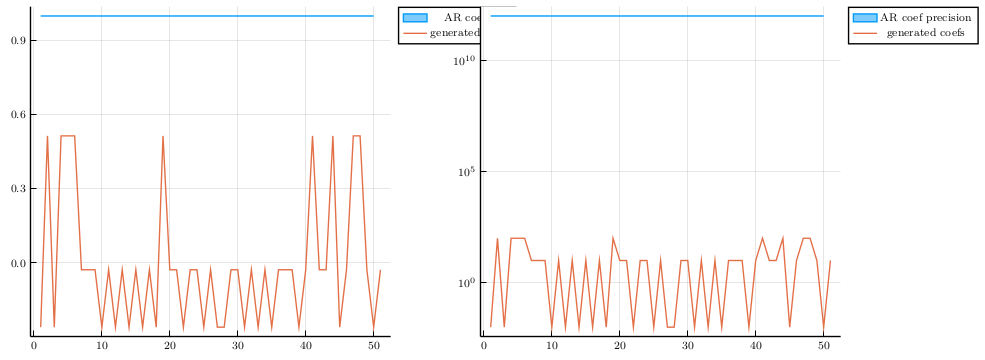

In [160]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 1
mγs = result.mγs
mθs = result.mθs

p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

In [143]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(result.mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .+  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .-  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


In [144]:
mγs = result.mγs
real_states = last.(findmax.(gen_states))

plt_gamma = @pgf Axis(
{   xlabel="frame "*L" \sharp",
    xmin=0.0,
    legend_pos = "north east",
    legend_cell_align="{left}",
    grid = "major",
    ylabel=L"\gamma",
    legend_style = "{nodes={scale=0.5, transform shape}}",
},
Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [prec_set[state] for state in real_states[1:end-1]])), LegendEntry("generated"),
Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mγs[end]))),
Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .+  std.(mγs[end]))),
Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .-  std.(mγs[end]))),
Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
        raw"fill between [of=f and g]"), LegendEntry("inferred")
)

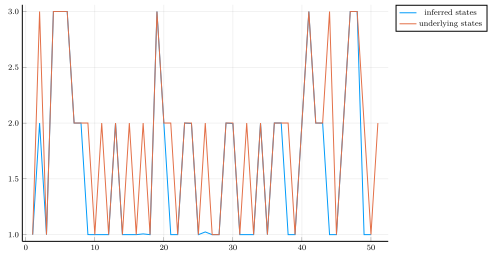

In [374]:
real_states = last.(findmax.(gen_states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

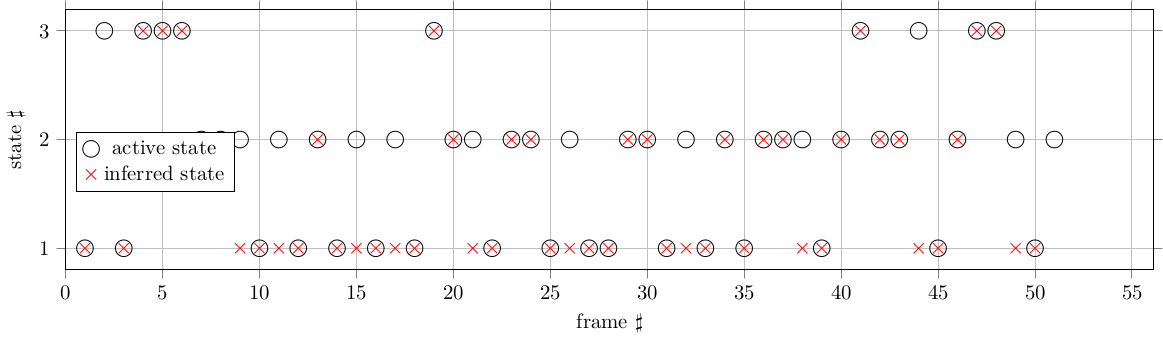

In [375]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    legend_style="{at={(0.01,0.3)},anchor=south west}",
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="20cm", height="6cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=4.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        )
    ), LegendEntry("active state"),
Plot(
    {fill="black", only_marks,color="red", mark_size=3.5, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(mzs[end])), y = round.(mean.(mzs[end][1:end]))
        ),
    ), LegendEntry("inferred state"),
)



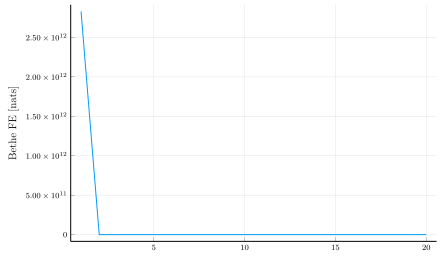

In [376]:
plot(mfe[1:end], label=:none, ylabel="Bethe FE [nats]")

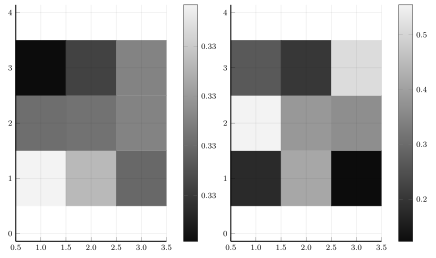

In [434]:
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

In [439]:
collect(1:n_states)

3-element Vector{Int64}:
 1
 2
 3

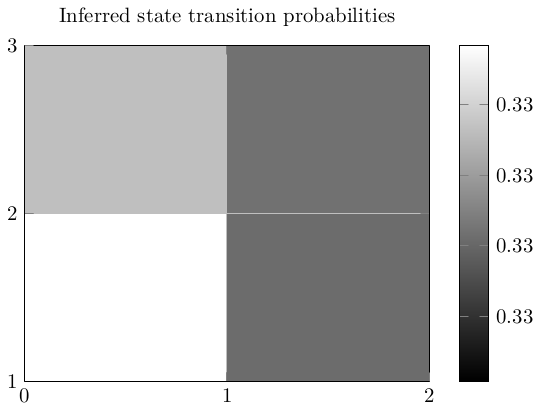

In [466]:
axis1 = @pgf Axis(
    {
        xtick=collect(0:n_states),
        ytick=collect(0:n_states),
        title="Inferred state transition probabilities",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/blackwhite",
        colorbar_style={"xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
    )